# How do you feel my dear? (P8)

## Andrea Pio Cutrera - 965591
### Università degli Studi di Milano - _Data Science and Economics_

**Text Mining and Sentiment Analysis**

Recently, **emotion detection in text** has received attention in the literature on **sentiment analysis**. Detecting emotions is important for studying human communication in different domains, including fictional scripts for TV series and movies. The project aims at studying fictional scripts of several movies and TV series under the emotional profile. In particular, the task of the project is threefold:

1. Create a **model to predict emotions in text** using available datasets as EmoBank or WASSA-2017 or Emotion Detection from Text as training sets (see below);
2. Emotions may be represented either as **categorical classes** or in a continuous space such as Valence-Arousal-Dominance (see for example Warriner, A. B., Kuperman, V., & Brysbaert, M. (2013). Norms of valence, arousal, and dominance for 13,915 English lemmas. Behavior research methods, 45(4), 1191-1207.)
3. Exploit the model to **study an emotional profile** of the **main characters** in **one of the movies** included in the Cornell Movie--Dialogs Corpus;
4. Study how this **emotional profile changes in time along** the evolution of the movie story and how it is affected by the various relations among the different characters.

### Import all the libraries we need

In [256]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#!pip install neattext
import neattext.functions as nfx

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import demoji
demoji.download_codes()

import nltk
# nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

#from keras.layers import Embedding
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, Input, Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D

from tensorflow.compat.v1.keras.layers import CuDNNLSTM

import warnings 
warnings.filterwarnings("ignore")

# to plot accuracy of neural nets training
def plot_history():
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Dataset: WASSA-2017 Shared Task on Emotion Intensity (EmoInt)
link: http://saifmohammad.com/WebPages/EmotionIntensity-SharedTask.html

- With the commands below you can get a folder with all the data they provide
1. Train, Development and Test data for each of the 4 emotions
2. Emotions are: **anger**, **fear**, **joy** and **sadness**

In [288]:
!mkdir emotions # create a folder called emotions

# training data
!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/anger-ratings-0to1.train.txt
!mv anger-ratings-0to1.train.txt emotions/anger_train # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/fear-ratings-0to1.train.txt
!mv fear-ratings-0to1.train.txt emotions/fear_train # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/joy-ratings-0to1.train.txt
!mv joy-ratings-0to1.train.txt emotions/joy_train # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/sadness-ratings-0to1.train.txt
!mv sadness-ratings-0to1.train.txt emotions/sadness_train # move and change name

# validation data
!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/anger-ratings-0to1.dev.gold.txt
!mv anger-ratings-0to1.dev.gold.txt emotions/anger_val # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/fear-ratings-0to1.dev.gold.txt
!mv fear-ratings-0to1.dev.gold.txt emotions/fear_val # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/joy-ratings-0to1.dev.gold.txt
!mv joy-ratings-0to1.dev.gold.txt emotions/joy_val # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/sadness-ratings-0to1.dev.gold.txt
!mv sadness-ratings-0to1.dev.gold.txt emotions/sadness_val # move and change name

# testing data
!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/anger-ratings-0to1.test.gold.txt
!mv anger-ratings-0to1.test.gold.txt emotions/anger_test # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/fear-ratings-0to1.test.gold.txt
!mv fear-ratings-0to1.test.gold.txt emotions/fear_test # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/joy-ratings-0to1.test.gold.txt
!mv joy-ratings-0to1.test.gold.txt emotions/joy_test # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/sadness-ratings-0to1.test.gold.txt
!mv sadness-ratings-0to1.test.gold.txt emotions/sadness_test # move and change name

mkdir: emotions: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 95686  100 95686    0     0   126k      0 --:--:-- --:--:-- --:--:--  126k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  130k  100  130k    0     0   160k      0 --:--:-- --:--:-- --:--:--  160k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92266  100 92266    0     0   160k      0 --:--:-- --:--:-- --:--:--  160k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92977  100 92977    0     0   162k      0 --:--:-- --:--:-- --:--:--  161k
  % Total    % Received

In [179]:
working_directory = !pwd                 # get present working directory
working_directory = working_directory[0] # get the full string 
working_directory

'/Users/andreacutrera/Desktop'

In [181]:
DIR = working_directory + "/emotions"    # go inside the folder created
#CATEGORIES = ["joy", "sadness", "fear", "anger"]
DIR

'/Users/andreacutrera/Desktop/emotions'

In [182]:
# load in variables the data just downloaded

joy_train = pd.read_csv(os.path.join(DIR, "joy_train"), sep="\t", header=None)
sadness_train = pd.read_csv(os.path.join(DIR, "sadness_train"), sep="\t", header=None)
fear_train = pd.read_csv(os.path.join(DIR, "fear_train"), sep="\t", header=None)
anger_train = pd.read_csv(os.path.join(DIR, "anger_train"), sep="\t", header=None)

joy_val = pd.read_csv(os.path.join(DIR, "joy_val"), sep="\t", header=None)
sadness_val = pd.read_csv(os.path.join(DIR, "sadness_val"), sep="\t", header=None)
fear_val = pd.read_csv(os.path.join(DIR, "fear_val"), sep="\t", header=None)
anger_val = pd.read_csv(os.path.join(DIR, "anger_val"), sep="\t", header=None)

joy_test = pd.read_csv(os.path.join(DIR, "joy_test"), sep="\t", header=None)
sadness_test = pd.read_csv(os.path.join(DIR, "sadness_test"), sep="\t", header=None)
fear_test = pd.read_csv(os.path.join(DIR, "fear_test"), sep="\t", header=None)
anger_test = pd.read_csv(os.path.join(DIR, "anger_test"), sep="\t", header=None)

In [183]:
print(joy_train.shape, sadness_train.shape, fear_train.shape, anger_train.shape)

(823, 4) (786, 4) (1147, 4) (857, 4)


In [184]:
print(joy_val.shape, sadness_val.shape, fear_val.shape, anger_val.shape)

(79, 4) (74, 4) (110, 4) (84, 4)


In [185]:
print(joy_test.shape, sadness_test.shape, fear_test.shape, anger_test.shape)

(714, 4) (673, 4) (995, 4) (760, 4)


In [186]:
# rename columns all in the same way to get homogeneous datasets which could be concatenated

joy_train.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'j'}, inplace=True)
joy_train['s'] = 0
joy_train['a'] = 0
joy_train['f'] = 0
joy_train = joy_train[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

joy_val.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'j'}, inplace=True)
joy_val['s'] = 0
joy_val['a'] = 0
joy_val['f'] = 0
joy_val = joy_val[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

joy_test.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'j'}, inplace=True)
joy_test['s'] = 0
joy_test['a'] = 0
joy_test['f'] = 0
joy_test = joy_test[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

sadness_train.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 's'}, inplace=True)
sadness_train['j'] = 0
sadness_train['a'] = 0
sadness_train['f'] = 0
sadness_train = sadness_train[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

sadness_val.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 's'}, inplace=True)
sadness_val['j'] = 0
sadness_val['a'] = 0
sadness_val['f'] = 0
sadness_val = sadness_val[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

sadness_test.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 's'}, inplace=True)
sadness_test['j'] = 0
sadness_test['a'] = 0
sadness_test['f'] = 0
sadness_test = sadness_test[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

anger_train.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'a'}, inplace=True)
anger_train['j'] = 0
anger_train['s'] = 0
anger_train['f'] = 0
anger_train = anger_train[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

anger_val.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'a'}, inplace=True)
anger_val['j'] = 0
anger_val['s'] = 0
anger_val['f'] = 0
anger_val = anger_val[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

anger_test.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'a'}, inplace=True)
anger_test['j'] = 0
anger_test['s'] = 0
anger_test['f'] = 0
anger_test = anger_test[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

fear_train.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'f'}, inplace=True)
fear_train['j'] = 0
fear_train['s'] = 0
fear_train['a'] = 0
fear_train = fear_train[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

fear_val.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'f'}, inplace=True)
fear_val['j'] = 0
fear_val['s'] = 0
fear_val['a'] = 0
fear_val = fear_val[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

fear_test.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'f'}, inplace=True)
fear_test['j'] = 0
fear_test['s'] = 0
fear_test['a'] = 0
fear_test = fear_test[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

In [187]:
# concatenate the datasets in order to get 3 separated datasets: train, test, validation

data_train = pd.concat([joy_train,
                        sadness_train,
                        fear_train,
                        anger_train])

data_val = pd.concat([joy_val,
                      sadness_val,
                      fear_val,
                      anger_val])

data_test = pd.concat([joy_test,
                       sadness_test,
                       fear_test,
                       anger_test])

In [188]:
data_train.head(2)

,id,text,sentiment,j,s,f,a
0,30000,Just got back from seeing @GaryDelaney in Burs...,joy,0.980,0.0,0.0,0.0
1,30001,Oh dear an evening of absolute hilarity I don'...,joy,0.958,0.0,0.0,0.0


In [189]:
data_val.head(2)

,id,text,sentiment,j,s,f,a
0,30823,"@theclobra lol I thought maybe, couldn't decid...",joy,0.312,0.0,0.0,0.0
1,30824,Nawaz Sharif is getting more funnier than @kap...,joy,0.700,0.0,0.0,0.0


In [190]:
data_test.head(2)

,id,text,sentiment,j,s,f,a
0,30902,You must be knowing #blithe means (adj.) Happ...,joy,0.583,0.0,0.0,0.0
1,30903,Old saying 'A #smile shared is one gained for ...,joy,0.500,0.0,0.0,0.0


In [191]:
data_train.shape, data_val.shape, data_test.shape, 

((3613, 7), (347, 7), (3142, 7))

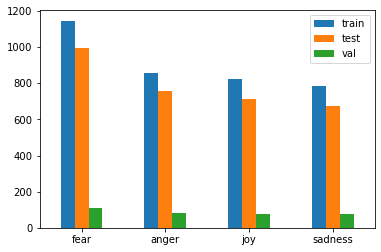

In [192]:
# datasets are pretty balanced

train = data_train['sentiment'].value_counts()
test = data_test['sentiment'].value_counts()
val = data_val['sentiment'].value_counts()

index = ['fear', 'anger', 'joy', 'sadness']
df = pd.DataFrame({'train': train,
                   'test': test,
                   'val': val}, index=index)
ax = df.plot.bar(rot=0)

### Now we start to clean up our texts

In [288]:
data_train['text'][:20]

0     Just got back from seeing @GaryDelaney in Burs...
1     Oh dear an evening of absolute hilarity I don'...
2     Been waiting all week for this game ❤️❤️❤️ #ch...
3     @gardiner_love : Thank you so much, Gloria! Yo...
4     I feel so blessed to work with the family that...
5     Today I reached 1000 subscribers on YT!! , #go...
6     @Singaholic121 Good morning, love! Happy first...
7     #BridgetJonesBaby is the best thing I've seen ...
8     Just got back from seeing @GaryDelaney in Burs...
9     @IndyMN I thought the holidays could not get a...
10                 I'm just still . So happy .\nA blast
11                     It's meant to be!! #happy #happy
12                 💥⚖️Yeah‼️ PAUL‼️⚖️💥  #glorious #BB18
13    My morning started off amazing!! Hopefully the...
14    😱 @cailamarsai you've had me 😂 😂 the whole tim...
15             @iamTinaDatta love you so much #smile 😊😊
16    @WyoWiseGuy @LivingVertical however, REI did o...
17    2 days until #GoPackGo and 23 days until #

In [289]:
sample_text = "@andreacutrera ToDAy 20-04-2022 I'm \"very happy\" 💥⚖️Yeah‼️, If you ,..* want 'to' < wrITE to me use my #email andreacutrera@gmail.com or reach me in the following link: https://github.com/andreacutrera/comics_faces_recognizer otherwise call me: +393335243648569 #machinelearning #deeplearning #itworks ❤️❤️❤️"
sample_text

'@andreacutrera ToDAy 20-04-2022 I\'m "very happy" 💥⚖️Yeah‼️, If you ,..* want \'to\' < wrITE to me use my #email andreacutrera@gmail.com or reach me in the following link: https://github.com/andreacutrera/comics_faces_recognizer otherwise call me: +393335243648569 #machinelearning #deeplearning #itworks ❤️❤️❤️'

In [290]:
sample_text = nfx.remove_emails(sample_text)
sample_text

'@andreacutrera ToDAy 20-04-2022 I\'m "very happy" 💥⚖️Yeah‼️, If you ,..* want \'to\' < wrITE to me use my #email  or reach me in the following link: https://github.com/andreacutrera/comics_faces_recognizer otherwise call me: +393335243648569 #machinelearning #deeplearning #itworks ❤️❤️❤️'

In [291]:
sample_text = nfx.remove_numbers(sample_text)
sample_text

'@andreacutrera ToDAy -- I\'m "very happy" 💥⚖️Yeah‼️, If you ,..* want \'to\' < wrITE to me use my #email  or reach me in the following link: https://github.com/andreacutrera/comics_faces_recognizer otherwise call me: + #machinelearning #deeplearning #itworks ❤️❤️❤️'

In [292]:
sample_text = nfx.remove_urls(sample_text)
sample_text

'@andreacutrera ToDAy -- I\'m "very happy" 💥⚖️Yeah‼️, If you ,..* want \'to\' < wrITE to me use my #email  or reach me in the following link:  otherwise call me: + #machinelearning #deeplearning #itworks ❤️❤️❤️'

In [293]:
sample_text = nfx.remove_userhandles(sample_text)
sample_text

'  ToDAy -- I\'m "very happy" 💥⚖️Yeah‼️, If you ,..* want \'to\' < wrITE to me use my #email  or reach me in the following link:  otherwise call me: + #machinelearning #deeplearning #itworks ❤️❤️❤️'

In [294]:
sample_text = demoji.replace_with_desc(sample_text)
sample_text

'  ToDAy -- I\'m "very happy" :collision::balance scale:Yeah:double exclamation mark:, If you ,..* want \'to\' < wrITE to me use my #email  or reach me in the following link:  otherwise call me: + #machinelearning #deeplearning #itworks :red heart::red heart::red heart:'

In [295]:
# separate the description of emoji which are linke by ":"
sample_text = re.sub(":", " ", sample_text)
sample_text

'  ToDAy -- I\'m "very happy"  collision  balance scale Yeah double exclamation mark , If you ,..* want \'to\' < wrITE to me use my #email  or reach me in the following link   otherwise call me  + #machinelearning #deeplearning #itworks  red heart  red heart  red heart '

In [296]:
sample_text = nfx.remove_special_characters(sample_text)
sample_text

'  ToDAy  Im very happy  collision  balance scale Yeah double exclamation mark  If you  want to  wrITE to me use my email  or reach me in the following link   otherwise call me   machinelearning deeplearning itworks  red heart  red heart  red heart '

In [297]:
sample_text = nfx.remove_bad_quotes(sample_text)
sample_text

'  ToDAy  Im very happy  collision  balance scale Yeah double exclamation mark  If you  want to  wrITE to me use my email  or reach me in the following link   otherwise call me   machinelearning deeplearning itworks  red heart  red heart  red heart '

In [298]:
sample_text = nfx.remove_html_tags(sample_text)
sample_text

'  ToDAy  Im very happy  collision  balance scale Yeah double exclamation mark  If you  want to  wrITE to me use my email  or reach me in the following link   otherwise call me   machinelearning deeplearning itworks  red heart  red heart  red heart '

In [299]:
sample_text = nfx.remove_punctuations(sample_text)
sample_text

'  ToDAy  Im very happy  collision  balance scale Yeah double exclamation mark  If you  want to  wrITE to me use my email  or reach me in the following link   otherwise call me   machinelearning deeplearning itworks  red heart  red heart  red heart '

In [300]:
sample_text = nfx.remove_stopwords(sample_text)
sample_text

'ToDAy Im happy collision balance scale Yeah double exclamation mark want wrITE use email reach following link machinelearning deeplearning itworks red heart red heart red heart'

In [301]:
sample_text = nfx.remove_multiple_spaces(sample_text)
sample_text

'ToDAy Im happy collision balance scale Yeah double exclamation mark want wrITE use email reach following link machinelearning deeplearning itworks red heart red heart red heart'

In [302]:
sample_text = strip_lowercase_text(sample_text)
sample_text

'today im happy collision balance scale yeah double exclamation mark want write use email reach following link machinelearning deeplearning itworks red heart red heart red heart'

In [303]:
# clean text functions
# https://github.com/Jcharis/neattext/blob/master/neattext/functions/functions.py

def clean_emoji_output(text):
    return re.sub(":", " ", text)

def strip_lowercase(text):
    return text.strip().lower()


def clean_text(data):
    data['clean_text'] = data['text'].apply(nfx.remove_emails)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_numbers)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_urls)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_userhandles)
    data['clean_text'] = data['clean_text'].apply(demoji.replace_with_desc)
    data['clean_text'] = data['clean_text'].apply(clean_emoji_output)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_special_characters)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_bad_quotes)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_html_tags)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_punctuations)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_stopwords)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_multiple_spaces)
    data['clean_text'] = data['clean_text'].apply(strip_lowercase)

In [304]:
# apply the functions above defined

clean_text(data_train)
clean_text(data_val)
clean_text(data_test)

In [305]:
# shuffle our data

data_train = shuffle(data_train, random_state=42)
data_val = shuffle(data_val, random_state=42)
data_test = shuffle(data_test, random_state=42)

In [307]:
data_test['clean_text'].values[:20]

array(['happy birthday seed double exclamation mark double exclamation mark double exclamation mark renewtherivalry imyourdaddy cantbeatme madden tater',
       'n word normalized media wow words words frog boiling pot media',
       'depressing freaking close',
       'talkin shit trying offend youre petty fuck',
       'ultimately keithscott wasnt man hand arrest warrant thats know thats cause outrage',
       'new madden video gonna xbox ahole going face rolling eyes face rolling eyes struggles',
       'didnt bad situation great mate cant believe makes despair humanity',
       'magpies gathering help im going swooped terrorism',
       'need pout time getting nerves gbbo',
       'lol dk actually dropped table surprisingly arms warrior dps moment',
       'gabriel eventually start frowning gaining conciousness apparently painful tears formed',
       'sure yous young breadrins sling quick vote murky skeng votage',
       'literally dying amp living time catch twitter arent followi

### Tokenize the text we have cleaned in order to make a further normalization on words with the Lemmatizer

In [308]:
# tokenize
tt = TweetTokenizer()

data_train['tokenize'] = data_train.clean_text.str.lower().apply(tt.tokenize)
data_val['tokenize'] = data_val.clean_text.str.lower().apply(tt.tokenize)
data_test['tokenize'] = data_test.clean_text.str.lower().apply(tt.tokenize)

# lemmatize
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]
    
data_train['tokenize_lemmatized'] = data_train['tokenize'].apply(lemmatize_text)
data_val['tokenize_lemmatized'] = data_val['tokenize'].apply(lemmatize_text)
data_test['tokenize_lemmatized'] = data_test['tokenize'].apply(lemmatize_text)

In [309]:
data_val.head()

,id,text,sentiment,j,s,f,a,clean_text,tokenize,tokenize_lemmatized
59,10916,Note to self ~ Stop laughing at things that of...,anger,0.0,0.000,0.0,0.542,note self stop laughing things offend ok mad p...,"[note, self, stop, laughing, things, offend, o...","[note, self, stop, laughing, thing, offend, ok..."
35,40821,It feel like we lost a family member🙄😂,sadness,0.0,0.708,0.0,0.000,feel like lost family member face rolling eyes...,"[feel, like, lost, family, member, face, rolli...","[feel, like, lost, family, member, face, rolli..."
62,10919,"Why to have vanity sizes?Now sizes S,XS(evenXX...",anger,0.0,0.000,0.0,0.708,vanity sizesnow sizes sxsevenxxs big wtf dear ...,"[vanity, sizesnow, sizes, sxsevenxxs, big, wtf...","[vanity, sizesnow, size, sxsevenxxs, big, wtf,..."
4,10861,Sometimes I get mad over something so minuscul...,anger,0.0,0.000,0.0,0.708,mad minuscule try ruin somebodies life like lo...,"[mad, minuscule, try, ruin, somebodies, life, ...","[mad, minuscule, try, ruin, somebody, life, li..."
44,10901,You're so thirsty for the chance to disagree w...,anger,0.0,0.000,0.0,0.500,youre thirsty chance disagree w left dont real...,"[youre, thirsty, chance, disagree, w, left, do...","[youre, thirsty, chance, disagree, w, left, do..."


In [320]:
lengths_train = []
lengths_val = []
lengths_test = []

for i in range(len(data_train)):
    lengths_train.append(len(data_train['tokenize'].values[i]))
for i in range(len(data_val)):
    lengths_val.append(len(data_val['tokenize'].values[i]))
for i in range(len(data_test)):
    lengths_test.append(len(data_test['tokenize'].values[i]))

print(max(lengths_train), max(lengths_val), max(lengths_test))

79 19 32


In [321]:
lengths_train

[7,
 2,
 5,
 14,
 4,
 10,
 14,
 6,
 12,
 9,
 12,
 6,
 3,
 6,
 5,
 6,
 4,
 8,
 5,
 3,
 5,
 6,
 8,
 14,
 10,
 2,
 4,
 10,
 11,
 6,
 7,
 6,
 10,
 10,
 9,
 6,
 9,
 8,
 2,
 8,
 13,
 6,
 9,
 8,
 8,
 2,
 6,
 10,
 3,
 10,
 8,
 11,
 2,
 11,
 14,
 4,
 13,
 5,
 9,
 4,
 13,
 8,
 4,
 4,
 16,
 8,
 15,
 8,
 7,
 7,
 14,
 2,
 7,
 12,
 5,
 6,
 3,
 9,
 13,
 14,
 13,
 11,
 7,
 10,
 17,
 11,
 8,
 6,
 4,
 11,
 11,
 2,
 11,
 8,
 12,
 8,
 3,
 13,
 31,
 14,
 10,
 7,
 6,
 8,
 11,
 6,
 9,
 7,
 7,
 5,
 7,
 11,
 11,
 4,
 8,
 1,
 13,
 6,
 5,
 4,
 11,
 14,
 6,
 6,
 9,
 5,
 7,
 8,
 4,
 6,
 9,
 7,
 9,
 12,
 8,
 9,
 9,
 5,
 11,
 9,
 8,
 4,
 11,
 7,
 6,
 15,
 3,
 5,
 10,
 11,
 9,
 7,
 4,
 11,
 12,
 15,
 13,
 8,
 6,
 2,
 11,
 13,
 11,
 4,
 7,
 13,
 7,
 15,
 3,
 10,
 10,
 13,
 8,
 5,
 9,
 8,
 7,
 10,
 4,
 9,
 13,
 12,
 8,
 15,
 5,
 13,
 14,
 6,
 8,
 2,
 11,
 11,
 14,
 5,
 11,
 5,
 6,
 10,
 8,
 6,
 4,
 8,
 2,
 7,
 10,
 9,
 14,
 2,
 13,
 6,
 1,
 10,
 10,
 4,
 5,
 10,
 7,
 8,
 9,
 7,
 5,
 1,
 7,
 13,
 4,
 13,
 12,
 7,
 10,
 

### DeTokenize to get again a sequence of words as they were written, but with all our preprocessing applied

In [322]:
# detokenize

data_train['final_text'] = data_train.tokenize_lemmatized.apply(TreebankWordDetokenizer().detokenize)
data_val['final_text'] = data_val.tokenize_lemmatized.apply(TreebankWordDetokenizer().detokenize)
data_test['final_text'] = data_test.tokenize_lemmatized.apply(TreebankWordDetokenizer().detokenize)

In [323]:
data_train.tail()

,id,text,sentiment,j,s,f,a,clean_text,tokenize,tokenize_lemmatized,final_text
307,40307,Itching something #serious RN haven't slept bu...,sadness,0.0,0.542,0.0,0.000,itching rn havent slept considering taking lik...,"[itching, rn, havent, slept, considering, taki...","[itching, rn, havent, slept, considering, taki...",itching rn havent slept considering taking lik...
471,40471,LORD MAKE ME AN INSTRUMENT OF YOUR PEACE — Whe...,sadness,0.0,0.427,0.0,0.000,lord instrument peace theres hate let sow love...,"[lord, instrument, peace, theres, hate, let, s...","[lord, instrument, peace, there, hate, let, so...",lord instrument peace there hate let sow love ...
37,40037,@Markgatiss I'm surrounded by those Trump vote...,sadness,0.0,0.833,0.0,0.000,im surrounded trump voters youre right fucking...,"[im, surrounded, trump, voters, youre, right, ...","[im, surrounded, trump, voter, youre, right, f...",im surrounded trump voter youre right fucking ...
751,10751,@pianimadi regarde tes snap,anger,0.0,0.000,0.0,0.312,regarde tes snap,"[regarde, tes, snap]","[regarde, te, snap]",regarde te snap
418,10418,@AgentTinsley I believe that's what you call t...,anger,0.0,0.000,0.0,0.500,believe thats fury righteous,"[believe, thats, fury, righteous]","[believe, thats, fury, righteous]",believe thats fury righteous


In [324]:
data_train.final_text.values[10]

'chris williams yard shy joining yard club bowman walker amp roosevelt cfl'

### Once we have cleaned our text, we can split our training texts from labels

In [325]:
# train-validation-test split has been already done

#X_train, X_test, y_train, y_test = train_test_split(data.final_text,
#                                                    data.sentiment,
#                                                    test_size = 0.1,
#                                                    random_state = 42,
#                                                    stratify = data.sentiment)

#X_train, X_val, y_train, y_val = train_test_split(X_train,
#                                                  y_train,
#                                                  test_size = 0.1,
#                                                  random_state = 42,
#                                                  stratify = y_train)

In [326]:
# split texts from labels

X_train = data_train.final_text
y_train = data_train.sentiment

X_val = data_val.final_text
y_val = data_val.sentiment

X_test = data_test.final_text
y_test = data_test.sentiment

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape)

(3613,) (3613,) (3142,) (3142,) (347,) (347,)


In [327]:
X_train.head()

16               cant grieve black body pop pig brutality
1021                                            pop round
32                     love love love fun relaxationiskey
789     monday face punch monday face punch fight joke...
411                         lively amp lovely buffnpolish
Name: final_text, dtype: object

In [328]:
y_train.head()

16      sadness
1021       fear
32          joy
789        fear
411         joy
Name: sentiment, dtype: object

### Now encode our labels into numbers from 0 to 3, this would allow us to one-hot-encode them

In [329]:
# numerical encoding of our labels

label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.fit_transform(y_test)
y_val_enc = label_encoder.fit_transform(y_val)

In [339]:
# alphabetical order
# 0: anger
# 1: fear
# 2: joy
# 3: sadness

print(y_train[199:203])
print(y_train_enc[199:203])

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
[0 1 3 2]


In [340]:
# one-hot-encode them

y_train = to_categorical(y_train_enc)
y_val = to_categorical(y_val_enc)
y_test = to_categorical(y_test_enc)

y_train[199:203]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [341]:
# here we use the Tokenizer of keras, fitting it on all our training and validation data, 
# getting the sequences and the words with the corresponding index (unique words)

num_words = 15000
tokenizer = Tokenizer(nb_words=num_words)
tokenizer.fit_on_texts(pd.concat([data_train, data_val]).final_text)
sequences = tokenizer.texts_to_sequences(pd.concat([data_train, data_val]).final_text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=50)

Found 8197 unique tokens.


In [342]:
# from these commands you can download the pre-trained word embeddings

# !curl -O http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

### Use the embedding with 200 features for each unique word

In [343]:
GLOVE_DIR = os.getcwd()
embeddings_index = {}

f = open(os.path.join(GLOVE_DIR, 'glove/glove.6B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [344]:
# Get the embedding matrix which is going to be put in the Embedding layer of the neural network architecture

embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [345]:
# Create the keras Embedding layer with 10K words specifying that the weights here are not trainable
# because we are using a pre-trained model (glove twitter words with 200 features)

embedding_layer = Embedding(len(word_index) + 1,
                            200,
                            weights=[embedding_matrix],
                            input_length=50,
                            trainable=False)

In [346]:
# Convert texts into some numeric sequences and make the length of all numeric sequences equal 

X_train_seq = tokenizer.texts_to_sequences(X_train) 
X_train_pad = pad_sequences(X_train_seq, maxlen = 50, padding = 'post') 

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen = 50, padding = 'post')

X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_seq, maxlen = 50, padding = 'post')

X_train_pad = np.array(X_train_pad)
X_test_pad = np.array(X_test_pad)
X_val_pad = np.array(X_val_pad)

## 1. Model with Embedding and 3 LSTMs
Note that if you have a GPU available, just specify **CuDNNLSTM** instead of **LSTM**. It does the same things but **5x** faster.

In [347]:
# number of classes

class_num = 4

In [380]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50, 
                             return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, 
                             return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50, 
                             return_sequences=False)))
model.add(Dense(class_num, 
                activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 200)           1639600   
                                                                 
 dropout_27 (Dropout)        (None, 50, 200)           0         
                                                                 
 bidirectional_21 (Bidirecti  (None, 50, 100)          100400    
 onal)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 50, 100)           0         
                                                                 
 bidirectional_22 (Bidirecti  (None, 50, 200)          160800    
 onal)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 50, 200)         

In [381]:
history = model.fit(X_train_pad, 
                    y_train, 
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_val_pad, y_val))

Epoch 1/20
29/29 [==============================] - 16s 350ms/step - loss: 1.2644 - accuracy: 0.4085 - val_loss: 1.1168 - val_accuracy: 0.5562
Epoch 2/20
29/29 [==============================] - 12s 403ms/step - loss: 0.9988 - accuracy: 0.5929 - val_loss: 0.9361 - val_accuracy: 0.6715
Epoch 3/20
29/29 [==============================] - 12s 398ms/step - loss: 0.8525 - accuracy: 0.6640 - val_loss: 0.8424 - val_accuracy: 0.6888
Epoch 4/20
29/29 [==============================] - 12s 401ms/step - loss: 0.7346 - accuracy: 0.7241 - val_loss: 0.8292 - val_accuracy: 0.7032
Epoch 5/20
29/29 [==============================] - 12s 410ms/step - loss: 0.6860 - accuracy: 0.7351 - val_loss: 0.7288 - val_accuracy: 0.7233
Epoch 6/20
29/29 [==============================] - 12s 405ms/step - loss: 0.5894 - accuracy: 0.7813 - val_loss: 0.6990 - val_accuracy: 0.7493
Epoch 7/20
29/29 [==============================] - 12s 408ms/step - loss: 0.5313 - accuracy: 0.8049 - val_loss: 0.7332 - val_accuracy: 0.7291

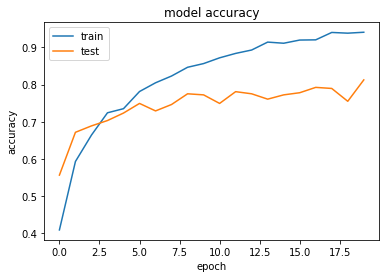

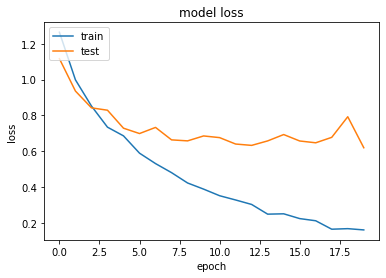

In [382]:
# call the function above defined to plot the training history among the epochs

plot_history()

In [383]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
y_true = np.argmax(y_test, axis=1)
print(metrics.classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.77      0.85      0.80       688
           1       0.82      0.77      0.80      1061
           2       0.83      0.87      0.85       679
           3       0.78      0.73      0.75       714

    accuracy                           0.80      3142
   macro avg       0.80      0.81      0.80      3142
weighted avg       0.80      0.80      0.80      3142



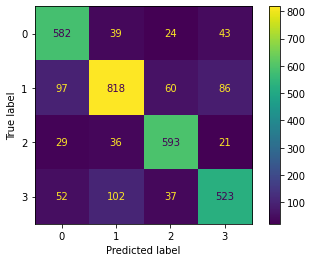

In [384]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_true))
cm.plot()

## 2. Model with Embedding, Convolutional layer and LSTM

In [385]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(128, 3, activation="relu"))
model.add(MaxPooling1D(2))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(class_num, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 200)           1639600   
                                                                 
 conv1d_6 (Conv1D)           (None, 48, 128)           76928     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 24, 128)          0         
 1D)                                                             
                                                                 
 lstm_28 (LSTM)              (None, 24, 200)           263200    
                                                                 
 dropout_30 (Dropout)        (None, 24, 200)           0         
                                                                 
 flatten_4 (Flatten)         (None, 4800)              0         
                                                     

In [386]:
history = model.fit(X_train_pad, 
                    y_train, 
                    epochs=20, 
                    batch_size=128,
                    validation_data=(X_val_pad, y_val))

Epoch 1/20
29/29 [==============================] - 4s 90ms/step - loss: 1.3114 - accuracy: 0.3767 - val_loss: 1.2783 - val_accuracy: 0.4150
Epoch 2/20
29/29 [==============================] - 2s 79ms/step - loss: 1.1210 - accuracy: 0.5004 - val_loss: 1.1097 - val_accuracy: 0.4841
Epoch 3/20
29/29 [==============================] - 2s 78ms/step - loss: 0.8188 - accuracy: 0.6823 - val_loss: 0.8672 - val_accuracy: 0.6542
Epoch 4/20
29/29 [==============================] - 2s 78ms/step - loss: 0.5705 - accuracy: 0.8013 - val_loss: 0.8673 - val_accuracy: 0.6801
Epoch 5/20
29/29 [==============================] - 3s 90ms/step - loss: 0.3897 - accuracy: 0.8688 - val_loss: 0.9027 - val_accuracy: 0.6974
Epoch 6/20
29/29 [==============================] - 3s 104ms/step - loss: 0.2629 - accuracy: 0.9078 - val_loss: 1.0998 - val_accuracy: 0.7147
Epoch 7/20
29/29 [==============================] - 3s 100ms/step - loss: 0.2144 - accuracy: 0.9341 - val_loss: 1.0233 - val_accuracy: 0.7262
Epoch 8/20


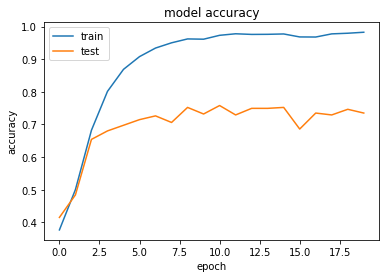

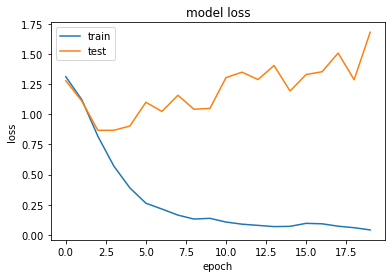

In [387]:
plot_history()

In [388]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
y_true = np.argmax(y_test, axis=1)

print(metrics.classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       763
           1       0.69      0.78      0.74       882
           2       0.86      0.74      0.79       830
           3       0.66      0.67      0.66       667

    accuracy                           0.74      3142
   macro avg       0.75      0.74      0.74      3142
weighted avg       0.75      0.74      0.74      3142



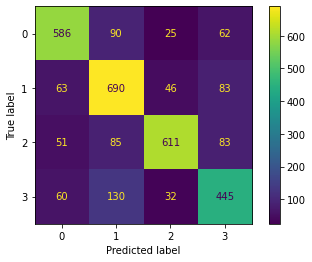

In [389]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_true))
cm.plot()

## 3. Model with LSTM and Convvolutional layers

In [358]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
model.add(GlobalMaxPooling1D())
model.add(Flatten())
#model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dense(class_num, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 200)           1639600   
                                                                 
 lstm_10 (LSTM)              (None, 50, 100)           120400    
                                                                 
 dropout_12 (Dropout)        (None, 50, 100)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 15, 128)           89728     
                                                                 
 conv1d_5 (Conv1D)           (None, 3, 128)            114816    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                      

In [359]:
history = model.fit(X_train_pad, 
                    y_train, 
                    epochs=20, 
                    batch_size=128,
                    validation_data=(X_val_pad, y_val))

Epoch 1/20
29/29 [==============================] - 5s 130ms/step - loss: 1.2373 - accuracy: 0.4343 - val_loss: 1.1146 - val_accuracy: 0.5476
Epoch 2/20
29/29 [==============================] - 3s 114ms/step - loss: 0.9027 - accuracy: 0.6396 - val_loss: 0.9176 - val_accuracy: 0.6369
Epoch 3/20
29/29 [==============================] - 3s 114ms/step - loss: 0.7237 - accuracy: 0.7191 - val_loss: 0.8452 - val_accuracy: 0.6830
Epoch 4/20
29/29 [==============================] - 3s 114ms/step - loss: 0.5766 - accuracy: 0.7805 - val_loss: 0.8085 - val_accuracy: 0.7003
Epoch 5/20
29/29 [==============================] - 3s 117ms/step - loss: 0.4608 - accuracy: 0.8262 - val_loss: 0.8200 - val_accuracy: 0.7233
Epoch 6/20
29/29 [==============================] - 3s 118ms/step - loss: 0.3553 - accuracy: 0.8660 - val_loss: 0.8251 - val_accuracy: 0.7579
Epoch 7/20
29/29 [==============================] - 3s 118ms/step - loss: 0.2700 - accuracy: 0.9006 - val_loss: 0.9018 - val_accuracy: 0.7406
Epoch 

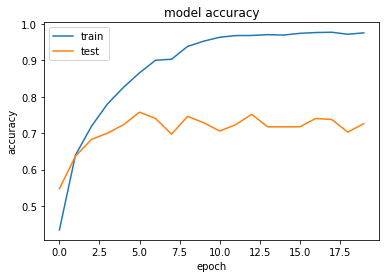

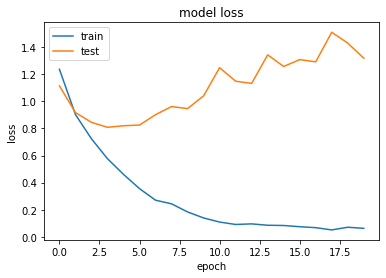

In [360]:
plot_history()

In [361]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
y_true = np.argmax(y_test, axis=1)

print(metrics.classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       820
           1       0.66      0.81      0.73       807
           2       0.82      0.83      0.82       706
           3       0.77      0.64      0.70       809

    accuracy                           0.75      3142
   macro avg       0.76      0.76      0.76      3142
weighted avg       0.76      0.75      0.75      3142



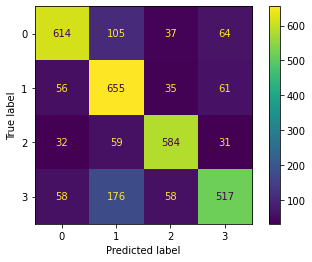

In [362]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_true))
cm.plot()